Todo:
1)year by year breakdown of florida code is runnning (needed to get the names of non deduped list since employee in multiple years)      

2)Need to clean up some charts...remove the first chart, add some state means from census

3) Department and titles some files have and some dont...lots of job titles...looksl like tedious work

4)for states w/ time series time trend

In [1]:
from ethnicolr import census_ln, pred_census_ln, pred_wiki_ln, pred_wiki_name, pred_fl_reg_ln, pred_fl_reg_name
import pandas as pd
from os import listdir
from os.path import isfile, join

root = '/Users/seunglee/Downloads/project/'


Using TensorFlow backend.


Unzip the .7z files to one directory...here it's "raw_data"

In [2]:
onlyfiles = [f for f in listdir(root+'raw_data') if (isfile(join(root+'raw_data', f))) & ('.csv' in f)]
pay_map = {'state':'Total Compensation', 'cities':'Salary', 'k12':'Salary', 'counties':'Salary', 'university':'Annual Salary'}




Data description over years government

In [30]:
def get_stats(df, counter, name, year='not specified'):
    df_description = pd.DataFrame()
    df_description.loc[counter, 'gov'] = name
    df_description.loc[counter, 'year'] = year
    df_description.loc[counter, 'state'] = 'fl'
    df_description.loc[counter, 'observations'] = df.shape[0]
    df_description.loc[counter, 'salary_avg'] = df[pay].mean()/1e3
    df_description.loc[counter, 'salary_median'] = df[pay].median()/1e3
    df_description.loc[counter, 'salary_min'] = df[pay].min()/1e3
    df_description.loc[counter, 'salary_max'] = df[pay].max()/1e3
    df_description.loc[counter, 'salary_std'] = df[pay].std()/1e3    
    return df_description

df_description = pd.DataFrame()
counter=0
for f in onlyfiles:
    df = pd.read_csv(root+'raw_data/'+f)
    name = f.split('_')[0]
    pay = pay_map[name]
    if(df[pay].dtype=='O'):
        df[pay] = df[pay].str.replace('$', '')
        df[pay] = df[pay].str.replace(',', '')
        df[pay] = df[pay].astype('double')
    df = df.loc[df[pay]>0]
    if('Year' in df.columns):
        for year in df.Year.unique():
            df_temp = df.loc[df.Year==year]
            df_description = df_description.append(get_stats(df_temp, counter, name, year=year))
            counter+=1
        df_description = df_description.append(get_stats(df, counter, name, year='all'))
        counter+=1
    else:
        df_description = df_description.append(get_stats(df, counter, name))
        counter+=1
    print(f)



state_1995_2014.csv
cities_1995_2014.csv
k12_1997_2014.csv
counties_1995_2014.csv
university_2014.csv


In [33]:
df_description.sort_values(by=['gov', 'year'], inplace=True)
df_description.head()

,gov,year,state,observations,salary_avg,salary_median,salary_min,salary_max,salary_std
35,cities,1997,fl,4178.0,22.114831,21.340345,0.00757,154.33210,11.285824
34,cities,1998,fl,4358.0,21.857303,21.679095,0.02656,105.20449,12.532980
33,cities,1999,fl,4088.0,23.155537,23.080510,0.00289,106.06240,13.210714
32,cities,2000,fl,3938.0,24.477641,24.509655,0.06206,106.07719,14.595703
31,cities,2001,fl,3927.0,25.465908,25.415780,0.00800,114.87889,15.156329


Imputes race for all the data files... The output is compressed and saved to "employee_race" subdirectory.

In [ ]:
for f in onlyfiles:
    df = pd.read_csv(root+'raw_data/'+f)
    df['ln'] = df['Employee Name'].str.split(',').str[0].str.lower()
    df['fn'] = df['Employee Name'].str.split(',').str[1].str.split(' ').str[1].str.strip()
    original_columns = list(df.columns)

    models_str = []
    for model in [census_ln, pred_census_ln, pred_wiki_ln, pred_wiki_name, pred_fl_reg_ln, pred_fl_reg_name]:
        model_name = model.__name__
        models_str.append('race_'+model_name)
        if(model_name=='census_ln'): 
            df = model(df, 'ln')
            df.replace('(S)', '0', inplace=True)
            race_cols = df.columns[df.columns.str.startswith('pct')]
            for col in race_cols:
                df[col] = df[col].astype('double')
            df['race'] = df[race_cols].idxmax(axis=1)
        elif(model_name=='pred_wiki_name'):
            df = model(df, 'fn', 'ln')
        elif(model_name=='pred_fl_reg_name'):
            df = model(df, lname_col='ln', fname_col='fn')
        else:
            df = model(df, 'ln')
        
        df.rename(columns={'race':'race_'+model_name}, inplace=True) 
    df = df[original_columns+models_str]
    df.to_csv(root+'employee_race/data/'+f.replace('.csv','_race.gz'), compression='gzip')
    print('done:', f)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
done: state_1995_2014.csv
done: cities_1995_2014.csv
done: k12_1997_2014.csv


Get distribution of races implied by the models


In [228]:
race_summary_not_wiki = pd.DataFrame()
race_summary_wiki = pd.DataFrame()
models = ['race_census_ln', 'race_pred_census_ln', 'race_pred_wiki_ln', 'race_pred_wiki_name',
          'race_pred_fl_reg_ln', 'race_pred_fl_reg_name']
for f in onlyfiles:
    temp = pd.read_csv(root+'employee_race/data/'+f, compression='gzip', index_col=[0])
    
    for model in models:
        temp_summary = pd.DataFrame(temp[model].value_counts()/temp.shape[0])
        temp_summary = temp_summary.T
        temp_summary['file'] = f.split('_')[0]
        if(model=='race_census_ln'):
            temp_summary.rename(columns={'pctwhite':'white', 'pcthispanic':'hispanic',
                                         'pctblack':'black', 'pctapi':'asian'}, inplace=True)
            temp_summary.drop(columns=['pct2prace', 'pctaian'], inplace=True)
            race_summary_not_wiki = race_summary_not_wiki.append(temp_summary)
        # ignore wiki models
        elif('wiki' in model):
            continue
            race_summary_wiki = race_summary_wiki.append(temp_summary)
        else:
            temp_summary.rename(columns={'nh_white':'white', 'nh_black':'black', 'api':'asian'}, inplace=True)            
            race_summary_not_wiki = race_summary_not_wiki.append(temp_summary)
            
#race_summary_wiki.to_csv(root+'employee_race/data/race_summary_wiki.csv')
race_summary_not_wiki.to_csv(root+'employee_race/data/race_summary_not_wiki.csv')



State mean from 2010 census.
https://en.wikipedia.org/wiki/Demographics_of_Florida

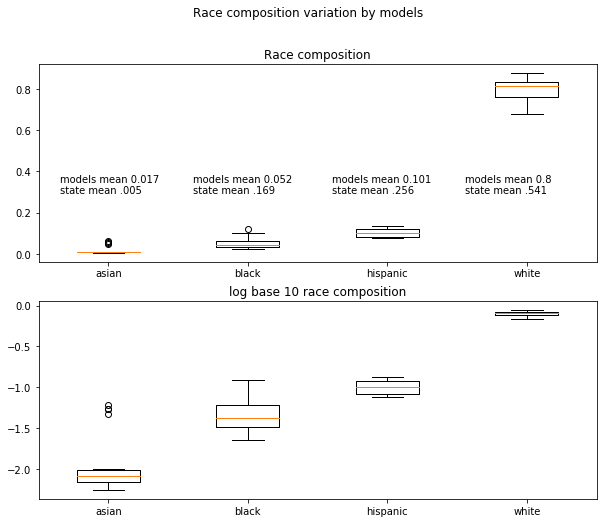

In [290]:

import matplotlib.pyplot as plt
import numpy as np
"""
data = race_summary_not_wiki[['asian', 'black', 'hispanic', 'white']]
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].boxplot(data.values)
ax[0].set_title('Race composition')
ax[0].set_xticklabels(['asian', 'black', 'hispanic', 'white'])
ax[1].boxplot(np.log10(data.values))
ax[1].set_xticklabels(['asian', 'black', 'hispanic', 'white'])
ax[1].set_title('log base 10 race composition')
ax[0].annotate('models mean '+str(np.round(race_summary_not_wiki.asian.mean(),3)), xy=(.1, .65), xycoords='figure fraction')
ax[0].annotate('state mean .005', xy=(.1, .63), xycoords='figure fraction')
ax[0].annotate('models mean '+str(np.round(race_summary_not_wiki.black.mean(),3)), xy=(.32, .65), xycoords='figure fraction')
ax[0].annotate('state mean .169', xy=(.32, .63), xycoords='figure fraction')
ax[0].annotate('models mean '+str(np.round(race_summary_not_wiki.hispanic.mean(),3)), xy=(.55, .65), xycoords='figure fraction')
ax[0].annotate('state mean .256', xy=(.55, .63), xycoords='figure fraction')
ax[0].annotate('models mean '+str(np.round(race_summary_not_wiki.white.mean(),3)), xy=(.77, .65), xycoords='figure fraction')
ax[0].annotate('state mean .541', xy=(.77, .63), xycoords='figure fraction')
plt.suptitle('Race composition variation by models')
plt.show()
"""

In [297]:
race_gb = race_summary_not_wiki.groupby('file').mean()
race_gb

,asian,black,hispanic,white
file,,,,
cities,0.006208,0.052275,0.078043,0.840693
counties,0.008109,0.050168,0.116789,0.797239
k12,0.007688,0.053522,0.128037,0.779791
state,0.009229,0.063880,0.082924,0.811701
university,0.054328,0.040263,0.097176,0.769101


[Text(0, 0, 'cities'),
 Text(0, 0, 'counties'),
 Text(0, 0, 'k12'),
 Text(0, 0, 'state'),
 Text(0, 0, 'university')]

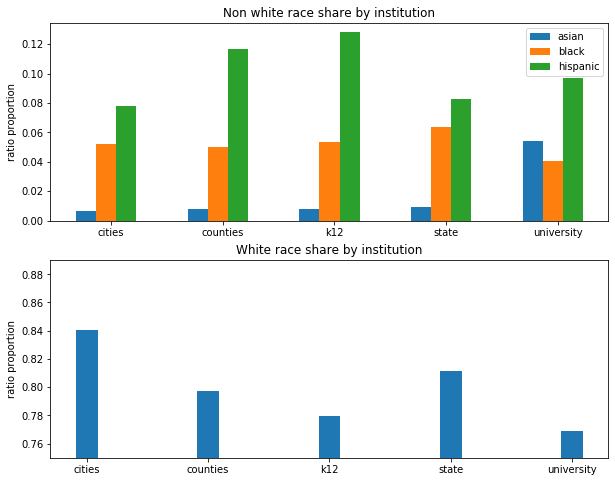

In [330]:
x = np.arange(len(race_gb))  
width = 0.35 
margin = 0.05
width = (1.-2.*margin)/len(race_gb)

fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].bar(x - 5*width/4, race_gb.asian, width, label='asian')
ax[0].bar(x - width/4, race_gb.black, width, label='black')
ax[0].bar(x + 3*width/4, race_gb.hispanic, width, label='hispanic')
ax[0].set_ylabel('ratio proportion')
ax[0].set_title('Non white race share by institution')
ax[0].set_xticks(x)
ax[0].set_xticklabels(race_gb.index)
ax[0].legend()
"""
ax[1].bar(x, race_gb.white, width, label='white')
ax[1].set_ylim([.75, .89])
ax[1].set_ylabel('ratio proportion')
ax[1].set_title('White race share by institution')
ax[1].set_xticks(x)
ax[1].set_xticklabels(race_gb.index)
"""